<a href="https://colab.research.google.com/github/raeubaen/Biological_Learning/blob/master/Bayesian_Cheating_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Cheating Detection

## Strategia

Consideriamo un gioco a tempo in cui S squadre devono risolvere N indizi $i_1,\, \dots, i_N$, che vengono forniti in un ordine non specificato. 
Supponiamo di possedere i dati relativi ai tempi assoluti in cui le squadre ricevono gli indizi da risolvere da parte del comitato. La numerazione degli indizi viene intesa rispetto alla squadra vincente. Nel nostro caso, ad esempio, l'indizio $i_{25}$, cioè il $25$-esimo dei `new team`, era "Tessuto", meglio noto come "Cencio".
Indichiamo come $I_i^{(s, t)}$ l'evento: le squadre $s$ e $t$ hanno collaborato durante la soluzione (o una ha comunicato la soluzione all'altra) dell'indizio $i$. Gli eventi $NI$, al contrario, indicano una non collaborazione. Se un evento $I_i^{(s, t)}$ si è verificato, ci aspettiamo che, nei dati in nostro possesso, la differenza nei tempi assoluti di soluzione dell'indizio $i$ tra le due squadre $s$ e $t$ sia piccola rispetto al caso $NI_i^{(s, t)}$. E' proprio questo ragionamento che ci consente di stimare il rapporto tra la probabilità di $I_i^{(s, t)}$ e di $NI_i^{(s, t)}$, entrambe condizionate all'osservazione di tempi assoluti $t^s_i$ e $t^t_i$ per gli indizi da $i_1$ a $i_N$, sulla base dei dati in nostro possesso. Tale rapporto rappresenta il fattore di Bayes dell'ipotesi $I_i^{(s, t)}$ rispetto alla $NI_i^{(s, t)}$, inferito a partire dai nostri dati. 
<br>Scendiamo più nel dettaglio.
<br>
Siano $P(D | I^{(s, t)}_{i_1} \dots I^{(s, t)}_{i_2})$ e $P(D | NI^{(s, t)}_{i_1} \dots NI^{(s, t)}_{i_2})$ le probabilità di osservare i tempi contenuti nei dati a nostra disposizione nelle due ipotesi di collaborazione e non collaborazione tra le squadre $s$ e $t$ durante la soluzione degli indizi compresi fra $i_1$ e $i_2$.
In particolare, dette $\Delta t^{(s, t)}_{i_1} \dots \Delta t^{(s, t)}_{i_2} $ le differenze nei tempi assoluti di soluzione tra le squadre $s$ e $t$ per gli indizi compresi fra $i_1$ e $i_2$, consideriamo $D$ come l'evento $ \forall i \in [i_1, i_2] \quad |\Delta t^{(s, t)}_i| < \max\limits_{j \in [i_1, i_2]} (|(\Delta t^{\mathrm{obs}})^{(s, t)}_j|) = M$, indicando con $|\Delta t^{(s, t)}_i|$ la relativa variabile casuale.
<br>
Nel caso di non collaborazione, possiamo assumere (grazie ad un test di normalità eseguito sui dati - vedi codice) che le differenze siano distribuite in modo gaussiano, dove la media $\mu$ e la dev. st. $\sigma$ sono calcolate su tutti gli indizi. 
Quindi:
$P(D | NI^{(s, t)}_{i_1} \dots NI^{(s, t)}_{i_2}) = \prod\limits_{i = i_1, \, \dots, i_2} P(|\Delta t^{(s, t)}_i| < M) $ con $\Delta t^{(s, t)}_i \sim \mathrm{Norm}(\mu, \sigma) \forall i$

Nel caso di collaborazione, possiamo assumere che le differenze $\Delta t^{(s, t)}_i$ siano distribuite in modo uniforme tra due valori $\mp a$, ossia che:
$P(D | I^{(s, t)}_{i_1} \dots I^{(s, t)}_{i_2}) = \prod\limits_{i = i_1, ..., i_2}P(|\Delta t^{(s, t)}_i| < M) $ con $\Delta t^{(s, t)}_i \sim \mathrm{Uniform}(-a, a) \forall i \in [i_i, i_2]$

Assumiamo, prima di fare inferenza dai dati, che il rapporto tra le probabilità (dette a priori) di collaborazione e di non collaborazione sia un numero $p$. 
Nel caso di ignoranza totale rispetto alla validità di una ipotesi o dell'altra, si prende solitamente $p = 1$. 
Poichè noi NON abbiamo sospetti a priori, anzi supponiamo che sia improbabile una collaborazione tra le squadre, assumiamo $p = 0.01 = 1 \%$.
Il likelihood ratio finale $\mathrm{LR} = \frac{P(D | I^{(s, t)}_{i_1} \dots I^{(s, t)}_{i_2})}{P(D | NI^{(s, t)}_{i_1} \dots NI^{(s, t)}_{i_2})}$  che si ottiene, riguardo alla collaborazione tra `skuato` e `corsari` dal loro 24-esimo indizio fino al 29-esimo, è maggiore di 14000. Perfino con questa ipotesi iniziale di presunta onestà, quindi, si ottiene un fattore di bayes $f = p * \mathrm{LR} = 140$, che è maggiore della soglia di 100 che si considera comunemente. *(Jeffreys, Harold (1998) [1961]. The Theory of Probability (3rd ed.). Oxford, England. p. 432. ISBN 9780191589676.)*

Iniziamo l'analisi eseguendo uno scatter plot dei tempi assoluti nei quali le squadre hanno risolto ciascun indizio.

In [1]:
# Importing external modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from scipy import stats

# Graphics settings
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

In [2]:
###---------------------------------
# Parsing excel files
path = os.getcwd()
files = os.listdir(path)

excel_files = [
  f for f in files 
  if f[-4:] == 'xlsx' and f[:3]!="hsl"
]
team_num = len(excel_files)
# Dictionary with teams as keys and Dataframes as values
dfs = {
  f[:-5]: pd.read_excel(f, usecols=[
    "nome indizio", "minuti da inizio", "minuti impiegati"
  ]) 
  for f in excel_files
}

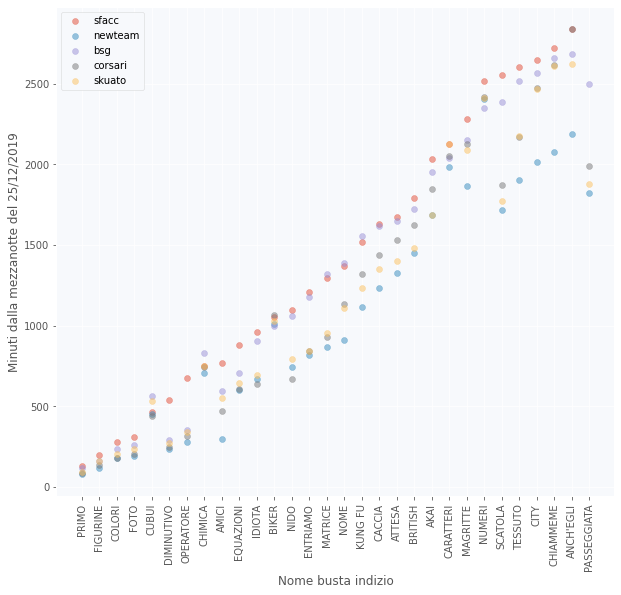

In [3]:
###--------------------------------------------
# Plotting minfromstart on (y) and riddle names on (x) for each team
fig, ax = plt.subplots(figsize=(10, 10))
for f, df in dfs.items():
  df.rename(columns={
    'nome indizio':'riddle', 
    'minuti da inizio':'minfromstart', 
    'minuti impiegati': 'mintaken',
  }, inplace=True)
  df.dropna(inplace=True)
  df.sort_values(by=['minfromstart'], inplace=True)
  ax.scatter(df.riddle.to_numpy()[:-1], df.minfromstart.to_numpy()[1:], label=f, alpha=0.5)

plt.xticks(rotation=90)
plt.legend()
ax.set(xlabel="Nome busta indizio", ylabel="Minuti dalla mezzanotte del 25/12/2019",)
fig.subplots_adjust(bottom=0.2)
plt.savefig("times.pdf")
plt.show() #blocking
plt.close()

Costruiamo ora il modello gaussiano per le differenze tra i tempi di risoluzione per ciascuna coppia di squadre, semplicemente calcolandone la media e la dev. st. La validità del modello verrà provata tramite il test di Kolmogorov-Smirnov (vedi codice). Plotteremo inoltre gli istogrammi delle differenze di tempo, indicando i $p-value$ del suddetto test, sovrapponendovi le relative pdf gaussiane. 

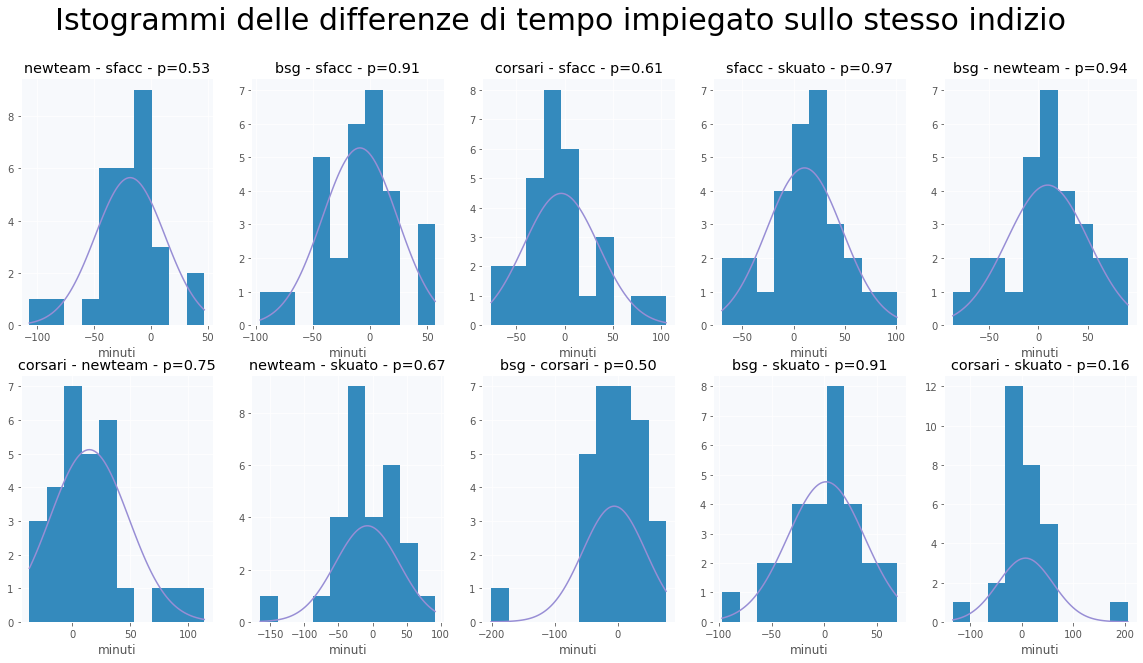

In [4]:
###-------------------------------------
# Constructing a gaussian model for the differences between all pairs of teams 
# in the time taken to solve each riddle 
missing = ["MIAO", "FINALCOUNTDOWN", "PASSEGGIATA"] # riddles not solved by all teams analyzed
for f, df in dfs.items():
  for m in missing:
    df = df[df.riddle != m] # excluding riddles in the missing list
  df.sort_values(by=['riddle'], inplace=True) # ordering by riddle name 
  dfs[f] = df.reset_index(drop=True)

# Calculating, saving in $diff and plotting averages and st. devs 
def shape_and_size(pairs = 5):
    a = int(np.sqrt(pairs))
    while pairs%a > 0: a -= 1
    return (a, pairs//a), (4*pairs//a, 5*a)

axs_shape, figsize = shape_and_size(pairs=team_num*(team_num-1)//2)
fig, axs = plt.subplots(*axs_shape, figsize=figsize)
i = 0
diff = pd.DataFrame(columns=["label", "team0", "team1", "mu", "sigma"])
# iterating over all couples of teams
for pair in itertools.combinations(dfs.keys(), 2): 
  pair = sorted(pair) #to be sure that the order is always the same
  label = pair[0] + " - " + pair[1]
  time_diff = dfs[pair[0]].mintaken - dfs[pair[1]].mintaken

  mu = np.mean(time_diff)
  sigma = np.std(time_diff)

  ###-------------------
  # Plotting histograms of time difference between teams
  # Testing for normality via Kolmogorov-Smirnov (KF) test
  #KF-test p-value - displayed in the histograms
  pvalue = stats.kstest((time_diff - mu)/sigma, 'norm').pvalue 

  minimum = np.min(time_diff)
  maximum = np.max(time_diff)
  x = np.linspace(minimum, maximum, 100)
  binwidth = 15
  bins=np.arange(minimum, maximum + binwidth, binwidth)

  axs[i//5, i%5].hist(time_diff)
  axs[i//5, i%5].hist(time_diff)
  #overlapping gaussian pdf curve and histogram
  axs[i//5, i%5].plot(x, len(time_diff)*binwidth*stats.norm.pdf(x, mu, sigma))
  axs[i//5, i%5].set(title=f"{label} - p={pvalue:.2f}", xlabel="minuti")
  i += 1

  # saving mu and sigma in the Dataframe
  diff = diff.append({
    "label": label, "team0": pair[0], "team1": pair[1],
     "mu": mu, "sigma": sigma,
  }, ignore_index=True)


fig.suptitle('Istogrammi delle differenze di tempo impiegato sullo stesso indizio', fontsize=30)
plt.savefig("hist.pdf")
plt.show()
plt.close()

Mostriamo ora le medie e le deviazioni standard ottenute, rappresentandole sotto forma di punti con incertezza a 1 $\sigma$.

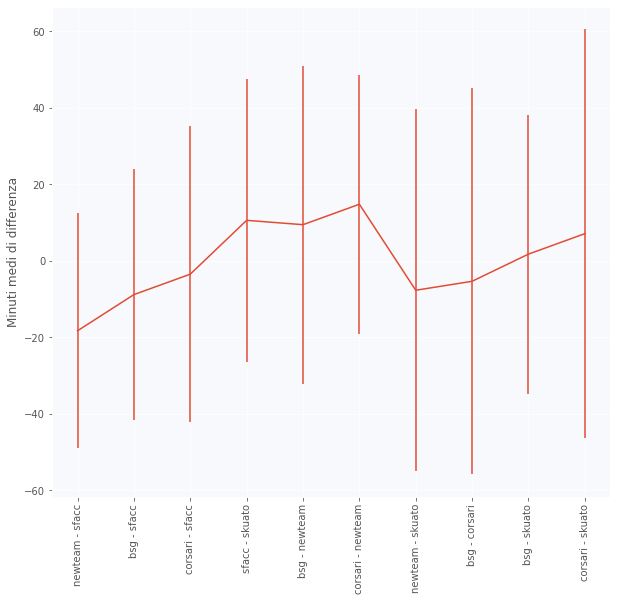

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.errorbar(diff.label, diff.mu, yerr=diff.sigma)
plt.xticks(rotation=90)
ax.set(ylabel="Minuti medi di differenza")
fig.subplots_adjust(bottom=0.2)
plt.savefig("diff.pdf")
plt.show() #blocking
plt.close()

Calcoliamo finalmente i fattori di Bayes per tutte le coppie di squadre e per tutte i valori possibili di $t_1$ e $t_2$, normalizzando e clippando preliminarmente i risultati ottenuti a 1000 per escludere fattori troppo bassi.

Verra infine plottato un grafico riassuntivo con una heatmap per ogni coppia di squadre, colorata in base ai fattori di bayes collaborazione/non-collaborazione per ciascun intervallo di tempi $t_1$ e $t_2$.


Come parametro della distribuzione uniforme (vedi sopra) prendiamo $a = 10 \, \mathrm{min}$ ( ` unif_range `  nel codice), considerando che sia orientativamente l'intervallo di tempo che passa tra il momento in cui una squadra (o le due squadre...) risolvono e il momento in cui il comitato riceve la soluzione (che è il dato in nostro possesso).

In [63]:
riddle_num = 29

###-------------------------------------
### Function to evaluate bayes factors
def bayes_factor(pair, t1, t2, unif_range):
  if t1==t2: return 0
  t1, t2 = min(t1, t2), max(t1, t2)
  dt = t2 - t1 # number of riddles during which the fraud is suspected

  pair = sorted(pair) 
  label = pair[0] + " - " + pair[1]

  # re-ordering by minfromstart
  for i in range(2):
    dfs[pair[i]].sort_values(by=['minfromstart'], inplace=True)
    dfs[pair[i]] = dfs[pair[i]].reset_index(drop=True)

  # calculating time differences from t1 to t2
  time_diff = (dfs[pair[0]].minfromstart - dfs[pair[1]].minfromstart).to_numpy()[t1:t2]

  # extracting mu and sigma from the Dataframe
  df = diff[diff.label==label]
  m, s = df.mu.iloc[0], df.sigma.iloc[0]

  max_diff = np.max(np.abs(time_diff)) # maximum time difference from t1 to t2

  norm_cum, unif_cum = stats.norm.cdf, stats.uniform.cdf
  ## probability that time differences are less than $max_diff for $dt times,
  # given that there is no fraud (gaussian distribution)
  lhood_no_fraud = (
    norm_cum(max_diff, m, s) - norm_cum(-max_diff, m, s)
    )**dt
  ## probability that time differences are less than $max_diff for $dt times,
  # given that there is a fraud (uniform distribution between -/+$unif_range)
  lhood_fraud = (
      unif_cum(max_diff, - unif_range, unif_range) 
        - 
      unif_cum(- max_diff, - unif_range, unif_range)
    )**dt
  bf = (lhood_fraud+1e-40)/(lhood_no_fraud+1e-40)
  threshold = 1000 # at prior ratio p=0.1
  if bf > threshold:
    print(f"Probable Cheat Detected: {label}, from riddle {t1} to {t2} - Bayes Factor: {bf:.0f}")
  return bf

La funzione `bayes_factor` non è facilmente vettorizzabile, poiché gli argomenti `t1` e `t2` sono utilizzati come per lo slicing dei vettore `time_diff`.
Useremo quindi `np.vectorize`, in una versione adatta all'uso di array masked, poiché, essendo $t_2>t_1$, le nostre matrici sono triangolari.

Probable Cheat Detected: corsari - skuato, from riddle 24 to 28 - Bayes Factor: 2109
Probable Cheat Detected: corsari - skuato, from riddle 24 to 29 - Bayes Factor: 14423
Probable Cheat Detected: corsari - skuato, from riddle 25 to 29 - Bayes Factor: 2124
Probable Cheat Detected: corsari - skuato, from riddle 24 to 28 - Bayes Factor: 2109
Probable Cheat Detected: corsari - skuato, from riddle 24 to 29 - Bayes Factor: 14423
Probable Cheat Detected: corsari - skuato, from riddle 25 to 29 - Bayes Factor: 2124


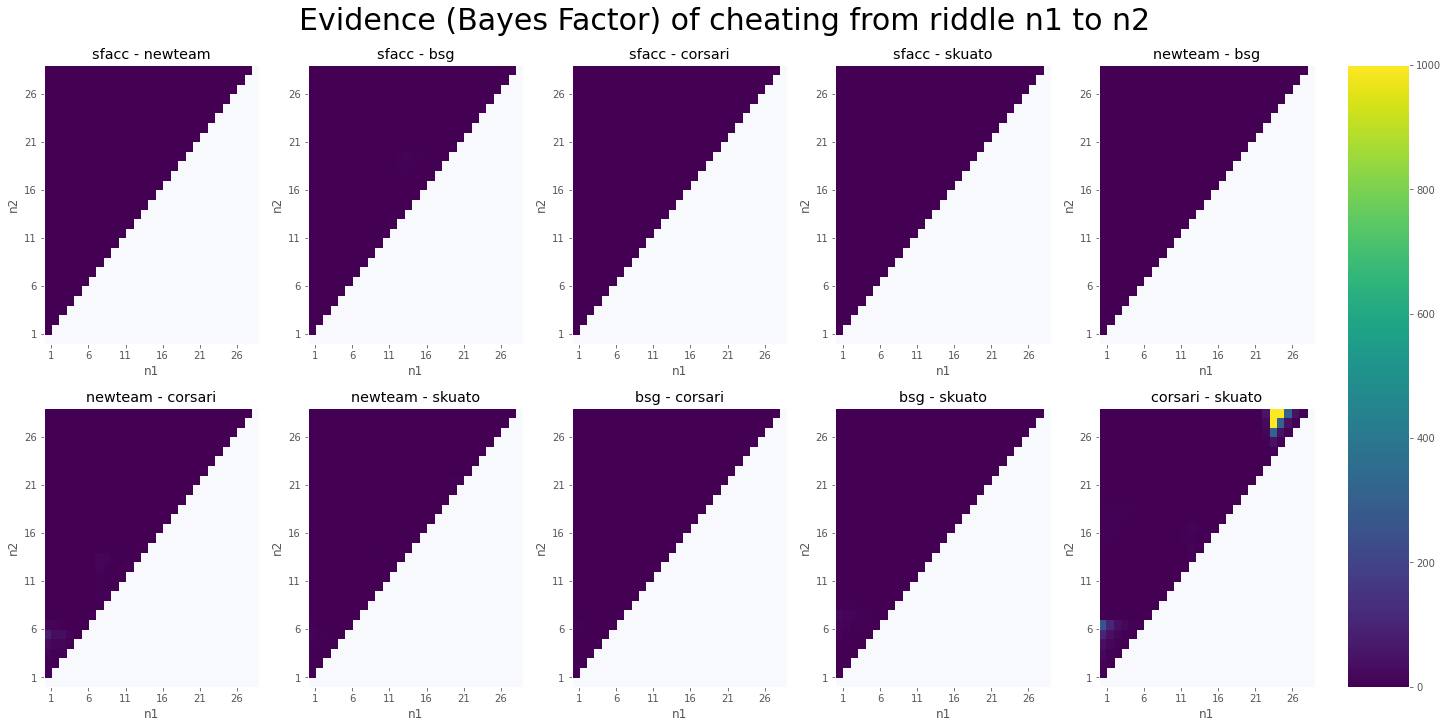

In [64]:
unif_range = 10 # maximum time difference allowed in case of fraud
start, end = 1, 29 # first and last riddle analyzed
###-------------
# Plotting heatmaps with two axis (x) and (y), 
# representing ratio of cheating likelihood to not-cheating likelihood from riddle (x) to (y)
# for each couple of teams

x = np.arange(start, end+1)
X, Y = np.meshgrid(x, x)
ticks = np.arange(start, end+1, 5)

mask = np.zeros_like(X, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
X, Y = np.ma.array(X, mask=mask), np.ma.array(Y, mask=mask)

fig, axs = plt.subplots(*axs_shape, figsize=figsize, constrained_layout=True)
i = 0
# iterating over all couples of teams
for pair in itertools.combinations(dfs.keys(), 2):
    vec_bayes_factor = np.vectorize(
      lambda X, Y: bayes_factor(pair, X, Y, unif_range)
    )

    ax = axs[i//5, i%5]
    im = ax.pcolormesh(vec_bayes_factor(X, Y), vmin=0, vmax=1000) #normalizing on the threshold
    ax.set(
      xticks=ticks, yticks=ticks, 
      xlabel="n1", ylabel="n2", 
      title = pair[0] + " - " + pair[1]
    )
    i += 1

fig.suptitle("Evidence (Bayes Factor) of cheating from riddle n1 to n2", fontsize=30)
plt.savefig(f"bayes.pdf")
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()
plt.close()

Come si vede dal grafico, l'unico segnale abbastanza forte da poter essere considerato significativo si riferisce a corsari e skuato, tra il 24-esimo ed il 29-esimo indizio. Riplottiamo dunque solo il grafico relativo a queste due squadre, evitando di clippare i valori a 1000.

Probable Cheat Detected: corsari - skuato, from riddle 24 to 28 - Bayes Factor: 2109
Probable Cheat Detected: corsari - skuato, from riddle 24 to 29 - Bayes Factor: 14423
Probable Cheat Detected: corsari - skuato, from riddle 25 to 29 - Bayes Factor: 2124
Probable Cheat Detected: corsari - skuato, from riddle 24 to 28 - Bayes Factor: 2109
Probable Cheat Detected: corsari - skuato, from riddle 24 to 29 - Bayes Factor: 14423
Probable Cheat Detected: corsari - skuato, from riddle 25 to 29 - Bayes Factor: 2124


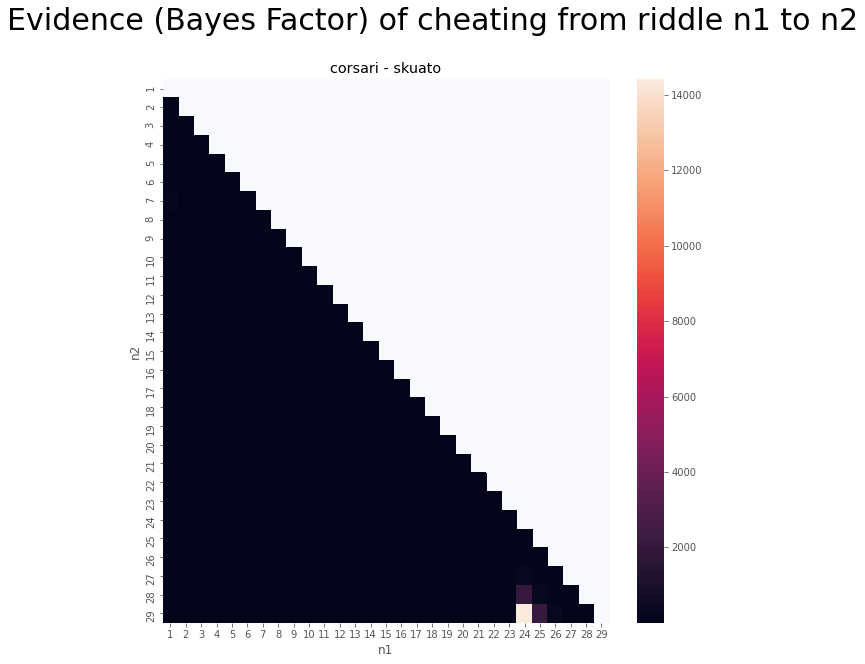

In [53]:
pair = ["corsari", "skuato"]
fig, ax = plt.subplots(figsize=(10, 10))
vec_bayes_factor = np.vectorize(
      lambda X, Y: bayes_factor(pair, X, Y, unif_range)
    )
sns.heatmap(vec_bayes_factor(X, Y), xticklabels=x, yticklabels=x, mask=mask)
ax.set(xlabel="n1", ylabel="n2", title = pair[0] + " - " + pair[1])
fig.suptitle("Evidence (Bayes Factor) of cheating from riddle n1 to n2", fontsize=30)
plt.savefig(f"bayes-corsari-skuato.pdf")
plt.show()
plt.close()

# Conclusioni

L'evidenza a favore di una collaborazione tra `corsari` e `skuato` tra il $24$-esimo ed il $29$-esimo indizio risulta statisticamente significativa. 